<a href="https://colab.research.google.com/github/s-choung/Research_utility/blob/main/bilgaard_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ase cathub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 104.0 MB/s eta 0:00:00


Connecting to database at http://api.catalysis-hub.org/graphql

Executing query:

{reactions(, pubId: "MamunHighT2019", sites: "~", products: "H") {
 totalCount
  edges {
    node { 
      surfaceComposition, reactionEnergy
      sites
      products
    }
  }
}}

Getting data from server...

Data fetched!
     Metal1 Metal2  Composition  ads_energy
0        Pt     Ti         0.75   -0.292810
1        Sc     Cu         0.75    0.095781
2        Cd     Pd         0.75    0.997302
3        Pt     Ti         0.75   -0.189930
4        Cd     Pd         0.75    0.401171
...     ...    ...          ...         ...
4323      V     Ag         0.75   -1.023127
4324      V     Pt         0.75   -0.992659
4325      V     Pt         0.75   -0.973047
4326      V     Pt         0.75   -0.532582
4327      V     Pd         0.75   -0.998508

[4328 rows x 4 columns]


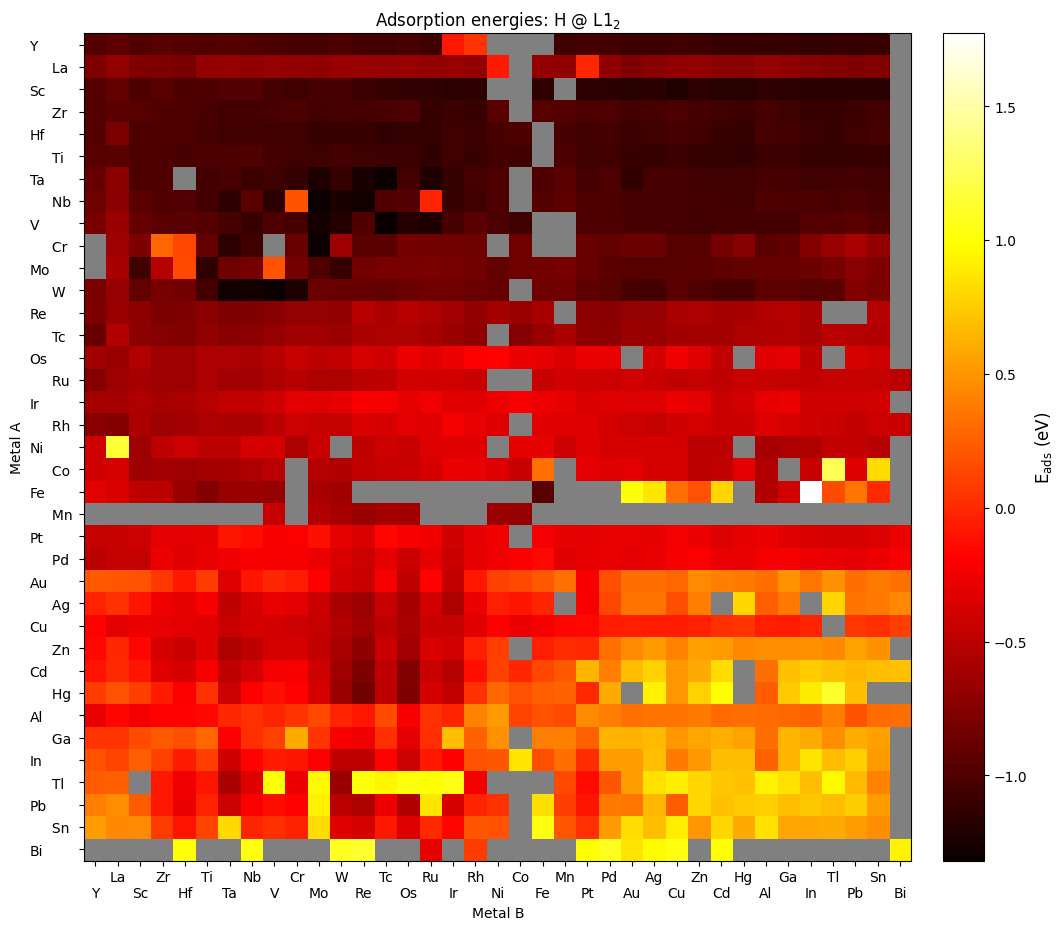

In [4]:
import sys
import json
import re
import numpy as np
import matplotlib
import pylab as p
from ase.db import connect
from ase.visualize import view
import matplotlib.transforms
from cathub.query import get_reactions
from tools import ordered_metals, get_AB_from_formula, references, site2int, site_labels
import pandas as pd


"""
Adsorbates includes: H, N, C, O, S, CH, NH, CH2, CH3, OH and H2O

sites can be:
'~', '~hollow', '~bridge, '~top', hollow|A_A_A|HCP, hollow|A_A_A|FCC, hollow|A_A_B|HCP, hollow|A_A_B|FCC,
bridge|A_A|A, bridge|A_A|B, bridge|A_B|A, bridge|B_B|B, top|A, top|B
Also you will have to specift the Structure Bericht symbol (SB_symbol) of the alloy, which can be L12 or L10

"""

import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

def analyze_adsorption(adsorbate):


    data = get_reactions(n_results='all',
                         pubId='MamunHighT2019',
                         sites=adsorption_site,
                         products=adsorbate,
                         columns=['surfaceComposition, reactionEnergy', 'sites', 'products'])

    data = data['reactions']
    totalCount = data['totalCount']
    edges = data['edges']
    site_points = (np.array(range(1, 14)) - 0.5) * 20 / 12

    # Define dim based on the length of ordered_metals
    dim = len(ordered_metals)
    EADS = np.zeros([dim, dim])
    SITES = np.zeros([dim, dim])
    EADS.fill(None)
    SITES.fill(None)

    # Initialize lists to store the data
    metal1_list = []
    metal2_list = []
    composition_list = []
    ads_energy_list = []

    for edge in edges:
        result = edge['node']

        adsorbates = list(result['products'].keys())
        prefactor_adsorbate = list(result['products'].values())[0]

        # Only include results with one adsorbate
        if len(adsorbates) > 1 or prefactor_adsorbate > 1:
            continue

        formula = result['surfaceComposition']
        E = result['reactionEnergy']
        sites = result['sites']

        site = list(sites.values())[0]
        if 'tilt' in site:
            continue
        site = site2int(site)

        A, B, SB = get_AB_from_formula(formula)
        if SB != 'A1' and SB != SB_symbol:
            continue

        iA = ordered_metals.index(A)
        iB = ordered_metals.index(B)

        # Determine composition based on SB_symbol
        composition = 0.5 if SB == 'L10' else 0.75
        # Remove '\n' from metal names
        metal1 = metalstrx[iA].strip()
        metal2 = metalstrx[iB].strip()
        # Append data to lists
        metal1_list.append(metal1)
        metal2_list.append(metal2)
        composition_list.append(composition)
        ads_energy_list.append(E)

        if np.isnan(EADS[iA, iB]) or EADS[iA, iB] > float(E):
            EADS[iA, iB] = E
            SITES[iA, iB] = site
            if SB_symbol == 'L10':
                EADS[iB, iA] = E
                SITES[iB, iA] = site

    # Create a pandas DataFrame
    data_her = {
        'Metal1': metal1_list,
        'Metal2': metal2_list,
        'Composition': composition_list,
        'ads_energy': ads_energy_list
    }

    df = pd.DataFrame(data_her)
    return df, EADS
metalstrx = ['\n{}'.format(o) if i in range(0,37,2) else o for i, o in enumerate(ordered_metals)]
metalstry = ['     {}'.format(o) if i in range(1,37,2) else o for i, o in enumerate(ordered_metals)]
dim = len(ordered_metals)
adsorption_site = '~'
SB_symbol = 'L12'  # 'L10' or 'L12'
# Example usage:
adsorbate = 'H'
result_df, EADS = analyze_adsorption(adsorbate)
print(result_df)


""" Plot adsorption energies"""
fig = p.figure(figsize=(12, 12))
cmap = matplotlib.cm.hot
cmap.set_bad('gray', 1.)
p.imshow(EADS, cmap=cmap)


p.xticks(range(dim), metalstrx)
p.yticks(range(dim), metalstry)

offset = matplotlib.transforms.ScaledTranslation(-0.45, 0, fig.dpi_scale_trans)

ax = p.gca()
for label in ax.yaxis.get_majorticklabels():
    label.set_horizontalalignment('left')
    label.set_transform(label.get_transform() + offset)

p.xlabel('Metal B')
p.ylabel('Metal A')
p.colorbar(fraction=0.046, pad=0.035).set_label(label='E$_\mathrm{ads}$ (eV)', size=12)
p.title('Adsorption energies: {} @ {}$_{}$'.format(adsorbate, SB_symbol[:-1], SB_symbol[-1]))

p.subplots_adjust(left=0.15, bottom=0.1, top=0.9)

p.show()



In [5]:
print(result_df)

     Metal1 Metal2  Composition  ads_energy
0        Pt     Ti         0.75   -0.292810
1        Sc     Cu         0.75    0.095781
2        Cd     Pd         0.75    0.997302
3        Pt     Ti         0.75   -0.189930
4        Cd     Pd         0.75    0.401171
...     ...    ...          ...         ...
4323      V     Ag         0.75   -1.023127
4324      V     Pt         0.75   -0.992659
4325      V     Pt         0.75   -0.973047
4326      V     Pt         0.75   -0.532582
4327      V     Pd         0.75   -0.998508

[4328 rows x 4 columns]


In [6]:
result_df

,Metal1,Metal2,Composition,ads_energy
0,Pt,Ti,0.75,-0.292810
1,Sc,Cu,0.75,0.095781
2,Cd,Pd,0.75,0.997302
3,Pt,Ti,0.75,-0.189930
4,Cd,Pd,0.75,0.401171
...,...,...,...,...
4323,V,Ag,0.75,-1.023127
4324,V,Pt,0.75,-0.992659
4325,V,Pt,0.75,-0.973047
4326,V,Pt,0.75,-0.532582


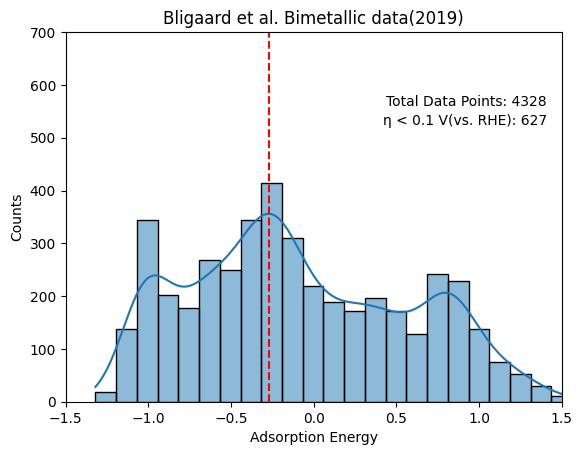

In [14]:


import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
sns.histplot(result_df['ads_energy'], kde=True)  # Create a histogram with a KDE (Kernel Density Estimation) curve

# Set x-axis limits to -1 and 1
plt.xlim(-1.5, 1.5)
plt.xlim(-1.5, 1.5)
plt.ylim(0, 700)
plt.title('Bligaard et al. Bimetallic data(2019)')

# Add a vertical line at x = -0.27
plt.axvline(x=-0.27, color='red', linestyle='--')

# Count the total number of data points
total_data_points = len(result_df)

# Count the number of |adsorp_energy + 0.27| < 0.1
count_eta = len(result_df[abs(result_df['ads_energy'] + 0.27) < 0.1])

# Add text at the upper right position for total data points
plt.text(0.97, 0.8, f'Total Data Points: {total_data_points}', transform=plt.gca().transAxes, fontsize=10, ha='right')

# Add text at the upper right position for η < 0.1 VRHE
plt.text(0.97, 0.75, f'η < 0.1 V(vs. RHE): {count_eta}', transform=plt.gca().transAxes, fontsize=10, ha='right')

plt.xlabel('Adsorption Energy')
plt.ylabel('Counts')
plt.show()



In [ ]:
!pip install adjustText

In [ ]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Filter the DataFrame based on the specified ranges
filtered_df = result_df[(result_df['ads_energy'] >= -0.57) & (result_df['ads_energy'] <= 0.03) & (result_df['η_HER'] >= -0.5) & (result_df['η_HER'] <= 0.5)]

# Create a scatter plot
plt.figure(figsize=(20, 12))
scatter = plt.scatter(filtered_df['ads_energy'], filtered_df['η_HER'], s=50, alpha=0.5)

# Label each data point with 'metal1' and 'metal2' for the filtered data
labels = [f"{row['Metal1']}_{row['Metal2']}" for i, row in filtered_df.iterrows()]

# Apply the force-directed algorithm to adjust label positions
texts = [plt.text(x, y, label, fontsize=8, alpha=0.8) for x, y, label in zip(filtered_df['ads_energy'], filtered_df['η_HER'], labels)]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

# Set axis labels and a title
plt.xlabel('HBE(eV)')
plt.ylabel('η(HER)(VRHE)')
plt.title('ads_energy vs η_HER (Filtered)')

# Set axis limits with reversed y-axis
plt.xlim([-0.77, 0.23])  # Adjust the range as needed
plt.ylim([0.5, -0.5])     # Reverse the y-axis

# Show the plot
plt.grid(True)
plt.show()
